# Lifelong Planning A* on Grids

You will implement a dynamic path planner for a point robot in a 2D terrain discretized as a grid world. The grid has 8-point connectivity; the neighbors of a given cell generally include the eight surrounding cells (or a subset of them, if the cell is on the boundary). The world is surrounded by four impassable walls, and it also contains a variety of terrain features. 

We can represent the grid using a 2D NumPy array indicating the status of each cell. Each cell takes on a value from the set $\{0, 1, 2, 3\}$ indicating the terrain feature at that cell. We provide four example grid worlds with different arrangements of terrain, all saved as `.npy` files. You can load an environment using `numpy.load()` and visualize it using `visualize_grid_world()`.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

from pathlib import Path
from enum import IntEnum
from heapq import *

In [25]:
class Environment(IntEnum):
    FLATLAND = 0
    POND = 1
    MOUNTAIN = 2
    OBSTACLE = 3
    EXPANDED = 4


def highlight_start_and_end(grid, cell, val):
    c_x, c_y = cell
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if np.sqrt((x - c_x) ** 2 + (y - c_y) ** 2) < 5:
                grid[int(x), int(y)] = val

    return grid


def visualize_grid_world(grid):
    _, ax = plt.subplots()
    grid_world = np.copy(grid)

    cmap = ListedColormap([
        "#006600",  # Flatland
        "#4d94ff",  # Pond
        "#FFA500",  # Mountain
        "#333333",  # Obstacle
    ])

    ax.imshow(grid_world, cmap=cmap)
    legend_elements = [
        Patch(facecolor="#006600", label="Flatland"),
        Patch(facecolor="#4d94ff", label="Pond"),
        Patch(facecolor="#FFA500", label="Mountain"),
        Patch(facecolor="#333333", label="Obstacle"),
        ]
    
    ax.set_title(f"Grid World Visualization")
    ax.legend(handles=legend_elements, 
              loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


def visualize_path(grid, start, goal, path):
    fig, ax = plt.subplots()
    grid_world = np.copy(grid)

    cmap = ListedColormap([
        "#006600",  # Flatland
        "#4d94ff",  # Pond
        "#FFA500",  # Mountain
        "#333333",  # Obstacle
        "#00AA00",  # Start & Goal
    ])

    grid_world = highlight_start_and_end(grid_world, start, len(cmap.colors) - 1)
    grid_world = highlight_start_and_end(grid_world, goal, len(cmap.colors) - 1)

    ax.imshow(grid_world, cmap=cmap)

    legend_elements = [
        Patch(facecolor="#006600", label="Flatland"),
        Patch(facecolor="#4d94ff", label="Pond"),
        Patch(facecolor="#FFA500", label="Mountain"),
        Patch(facecolor="#333333", label="Obstacle"),
        Patch(facecolor="#86592d", label="Expanded"),
        ]

    path_line, = ax.plot([], [], color='#FF0000', label='Path')

    if path:
        path_x, path_y = zip(*path)
        gw, = ax.plot(path_y, path_x, color='#FF0000', label='Path')
        legend_elements.append(Patch(facecolor='#FF0000', label='Path'))

    ax.set_title(f"Grid World Path Planning Result")
    ax.legend(
        handles=legend_elements, 
        loc='upper center', 
        bbox_to_anchor=(0.5, 0), 
        ncol=3
        )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


def visualize_expanded(grid, start, goal, expanded, path):
    fig, ax = plt.subplots()
    grid_world = np.copy(grid)

    cmap = ListedColormap([
        "#006600",  # Flatland
        "#4d94ff",  # Pond
        "#FFA500",  # Mountain
        "#333333",  # Obstacle
        "#86592d",  # Expanded
        "#00AA00",  # Start & Goal
    ])

    grid_world = highlight_start_and_end(grid_world, start, len(cmap.colors) - 1)
    grid_world = highlight_start_and_end(grid_world, goal, len(cmap.colors) - 1)

    if path:
        path_x, path_y = zip(*path)
        gw, = ax.plot(path_y, path_x, color='#FF0000', label='Path')

    # dumb bug fix
    fix_bug = grid_world[0, -1]
    grid_world[0, 3] = 4
    gw = ax.imshow(grid_world, cmap=cmap)
    grid_world[0, 3] = fix_bug

    legend_elements = [
        Patch(facecolor="#006600", label="Flatland"),
        Patch(facecolor="#4d94ff", label="Pond"),
        Patch(facecolor="#FFA500", label="Mountain"),
        Patch(facecolor="#333333", label="Obstacle"),
        Patch(facecolor="#86592d", label="Expanded"),
        Patch(facecolor='#FF0000', label='Path')
        ]

    expanded = [s for s in expanded if len(s) > 0]
    all_x, all_y = [], []

    for s in expanded:
        x, y = s
        all_x.append(x)
        all_y.append(y)
    grid_world[all_x, all_y] = Environment.EXPANDED
    gw.set_array(grid_world)

    ax.set_title(f"Grid World Expanded Cells Result")
    ax.legend(
        handles=legend_elements, 
        loc='upper center', 
        bbox_to_anchor=(0.5, 0), 
        ncol=3
        )
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


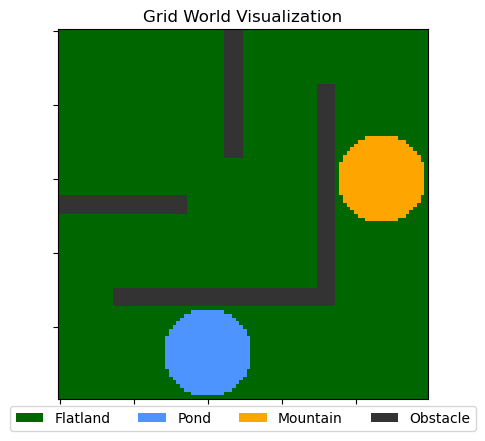

In [26]:
grid = np.load(f"worlds/world_1.npy")
visualize_grid_world(grid)

# `LPA_Planner` Class

You will complete the following `LPA_Planner` class. When we initialize a `LPA_Planner` object, we provide the `grid`, as well as `start` and `goal` coordinate tuples on the grid. In `__init__()`, we initialize the arrays `gridv`, `gridg`, and `gridh`. These contain, respectively, the $v$ values, $g$ values, and $h$ values (Euclidean distance) of all cells in the grid.

We also initialize `open_list`, which will be maintained using [`heapq`](https://docs.python.org/3/library/heapq.html) library functions, and insert the `start` node into it. Notice that each `open_list` item is a tuple containing the *key* of a node (which is used to order the list items) and then the node itself. Finally, we initialize a `parents` dictionary that will eventually contain the *parent* of each node seen. 

**Helper functions.** The `key()` of a node $n$ is computed as $(\min(v(n),g(n))+h(n), \min(v(n),g(n)))$. It is a tuple so that the second value is used if the first one is tied between two nodes. `cost()` returns the cost value of a node (determined by its feature), and `neighbors()` returns a list of all neighboring nodes. 

## Part 1: `update_node()`

Implement `update_node()`, which should perform the following updates given a `node` $n$:

* Set $g(n) = \min (v(p) + d \times c(n))$, where $p$ is a neighbor of $n$ and $c(n)$ is just the `cost` of $n$. The weight $d$ is $1$ if $p$ is a cardinal neighbor of $n$ and $\sqrt 2$ if $p$ is a diagonal neighbor. Also record the min neighbor of $n$ in the `parents` dictionary.

* If $n$ is currently in the open list with an outdated key, remove it.

* If $g(n) \neq v(n)$ and $n$ is not in the open list, insert it with its current key.

## Part 2: `compute_path()`

Implement `compute_path()`, which will compute and return an optimal path starting from the current state of the grid's values and open list. It should also define and update a *list* of expanded nodes. The following steps should then be performed while the first node in the open list has a smaller key than that of the goal, or while the goal remains inconsistent:

* Pop the first node off the open list. If it is overconsistent, set $v=g$ to make it consistent. Otherwise, set $v=\infty$ and call `update_node()` on it.

* Call `update_node()` on each of the neighbors of the popped node (make sure to skip the `start` node).

* Add the popped node to the `expanded` list.

Once the loop terminates, you can follow the `parents` dictionary of pointers from the goal back to the start node. You can then reverse this to return the `path` list, along with the `expanded` list.

In [27]:
#Note: I used Spyder as an IDE to help me program, it has a much faster workflow, clear variable tracker, and great plotting tools
#.    if chunks of code seem to magically appear at once, it is because I finsihed the routine using spyder
class LPA_Planner():
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.start = start 
        self.goal = goal 

        self.gridv = np.inf*np.ones((self.grid.shape[0], self.grid.shape[1]))
        self.gridg = np.inf*np.ones((self.grid.shape[0], self.grid.shape[1]))
        self.gridg[self.start] = 0 

        self.gridh = np.ones((self.grid.shape[0], self.grid.shape[1]))
        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1]):
                self.gridh[i,j] = 0.5 * ((self.goal[0]-i)**2 + (self.goal[1]-j)**2)**0.5

        self.open_list = [(self.key(self.start), self.start)]
        heapify(self.open_list)
        self.parents = {self.start: None}


    def key(self, node):
        return (min(self.gridv[node], self.gridg[node]) + self.gridh[node], 
                min(self.gridv[node], self.gridg[node]))


    def cost(self, node):
        if self.grid[node] == Environment.FLATLAND:
            return 1
        elif self.grid[node] == Environment.POND:
            return 0.5
        elif self.grid[node] == Environment.MOUNTAIN:
            return 2
        elif self.grid[node] == Environment.OBSTACLE:
            return np.inf


    def neighbors(self, node):
        neighbors = []
        adjacent = [[0, 1], [1, 0], [0, -1], [-1, 0],
                    [1, 1], [1, -1], [-1, 1], [-1, -1]]
        
        x, y = node
        for i, j in adjacent:
            if x + i >= 0 and x + i < self.grid.shape[0] and \
               y + j >= 0 and y + j < self.grid.shape[1] and \
               self.grid[x + i, y + j] != Environment.OBSTACLE:
                neighbors.append((x + i, y + j))
        return neighbors


    def update_costs(self, rows, cols, feature):
        self.grid[rows, cols] = feature
        for i in range(len(rows)):
            self.update_node((rows[i], cols[i]))


    def update_node(self, node):
        # TODO
        n=node
        #want to determine p by selecting the cheapest neighbor of n
        neighbors= self.neighbors(n)
        min_g= np.inf
        min_p= None
        g_n= None
        for p in neighbors:
  
            d=0
            #check if cardinal neighbor; or diagonal
            d = 1 if p[0] == n[0] or p[1] == n[1] else np.sqrt(2)
                
            v_p= self.gridv[p] 
   
            c_n=self.cost(n)
            g_n= v_p + d*(c_n)
            if g_n < min_g:
                min_g= g_n
                min_p= p
       
        p= min_p
        self.gridg[n]= min_g
        g_n=min_g
        self.parents[node]=p
     
        #lowest cost nodes are expanded first
        new_key= self.key(n)
        index=0
        for key, node in self.open_list:
            if node == n and new_key != key:
                self.open_list.pop(index)
                heapify(self.open_list)
            index+=1
            
        v_n=self.gridv[n]
        if (g_n != v_n) and ((new_key, n) not in self.open_list):
            heappush(self.open_list, ((new_key, n)))
        

    def compute_path(self):
        # TODO
        expanded = []
        path = []
        ol= self.open_list
        goal= self.goal

        while (ol and (ol[0][0] < self.key(goal) or self.gridv[goal] != self.gridg[goal])):
            n=ol.pop(0)[1]
            v_n=self.gridv[n]
            g_n=self.gridg[n]
            
            if v_n > g_n:
                v_n=g_n
                self.gridv[n]= v_n
            else:
                v_n=np.inf
                self.update_node(n)
                self.gridv[n]= v_n
            for neighbor in self.neighbors(n):
                if neighbor != self.start:
                    self.update_node(neighbor)
            expanded.append(n)
        print("done!")
        
        current_node=goal
        while current_node is not None:
            path.append(current_node)
            current_node= self.parents.get(current_node)
        
        return path, expanded

In [28]:
def main(searcher):
    path, expanded = searcher.compute_path()
    path_cost = 0
    for i in range(1,len(path)):
        d = 1 if path[i][0] == path[i-1][0] or path[i][1] == path[i-1][1] else np.sqrt(2)
        path_cost += d*searcher.cost(path[i])

    print(f"Path length: {len(path)}")
    print(f"Path cost: {path_cost}")
    print(f"Number of expanded states: {len(expanded)}")
    visualize_path(searcher.grid, searcher.start, searcher.goal, path)
    visualize_expanded(searcher.grid, searcher.start, searcher.goal, expanded, path)

After you finish your implementation, you can test it out by loading a sample world, specifying the start and goal locations, and then creating a new `LPA_Planner` object. You can then run the provided `main()` function to compute a path and show the results. An example is shown below with world 1 and start and goal locations $(10,10)$ and $(90,90)$. 

If all goes well, a path should be found by your planner. You should see the path length and cost, number of expanded states, and two figures, one showing the path and the other also showing expanded cells.

Initial planning...
done!
Path length: 141
Path cost: 152.7314933988261
Number of expanded states: 8231


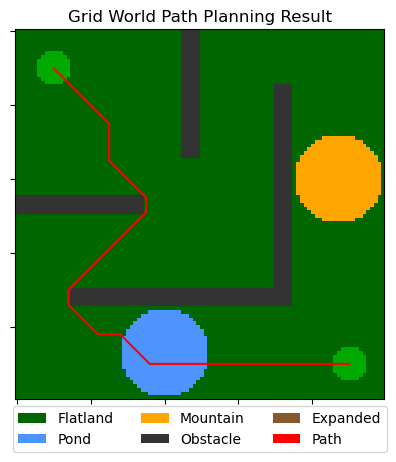

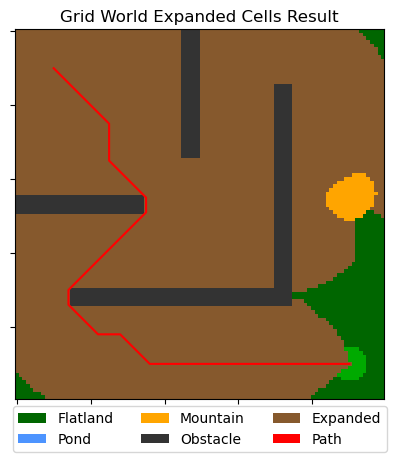

In [29]:
grid = np.load(f"worlds/world_1.npy")
start = (10, 10)
goal = (90, 90)

searcher = LPA_Planner(grid, start, goal)
print("Initial planning...")
main(searcher)

## Part 3: Analysis

Continuing from the example above, perform each of the following tasks in sequence. **It is important that you do not reset or create a new `LPA_Planner` object for each task.** The whole point of LPA is that its state persists, allowing it to do fast replanning. Show the outputs and answer the follow-up questions. 

* Change the goal from $(90,90)$ to $(80,85)$ and recompute the optimal path. Report and explain your observations about the set of expanded states in the new search. 

* Suppose we've discovered a new `MOUNTAIN` from rows 75 to 85 and from columns 60 to 70. Use the `update_costs()` function in `LPA_searcher` to make these changes, and then compute a new optimal path. How does the path change, how many states are expanded, and where are the expanded states generally located?

* Suppose we've discovered a new `POND` from rows 20 to 40 and from columns 55 to 65. Use the `update_costs()` function in `LPA_searcher` to make these changes, and then compute a new optimal path. How does the path change, how many states are expanded, and where are the expanded states generally located?



---
---

First bullet answer (Changed Goal):
* With a new goal, the optimal path stays on the same route, and is just shorter, as the goal was moved slightly in flatland. The cost also decreases from 152 to 146, as the goal is closer.
* Additionally, no new states are expanded, as the goal is already on the path previously found. For this reason, no new states need to be expanded since it was already explored on the optimal path.
---
Second bullet answer (mountain):
* With the addition of the mountain on the bottom of the map, the path changes to change its trajectory in the pond to wrap around the mountain, avoiding the increased cost of traversing the new mountain by moving around it. The cost of the path increases to 149 as well.
* 1758 states are expanded, genreally located at and around the mountain, as the algorithm tried to see the cost of going through the mountain and around it in various ways.
---

Third bullet answer (pond):
* With the pond now on the map, the path is redrawn, going up on the map, instead of down. Due in part to the mountain at the bottom of the map, and a new feature to be explored, the algorithm explores and searches the top right of the map, allowing for a path to be found around the large mountain on the right. The path cost also stays around 146 with this re-route.
* 2849 states are expanded, as the top right region of the map wasnt explored in the previous searches. The expanded states are all located on the top right of the map, starting at the pond, and moving down towards the goal.
---


done!
Path length: 136
Path cost: 146.66042558696063
Number of expanded states: 0


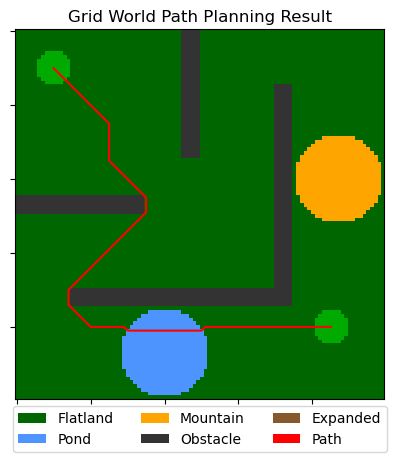

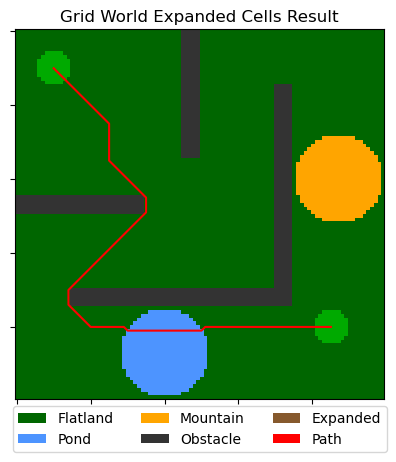

In [30]:
searcher.goal=(80, 85)
main(searcher)

done!
Path length: 136
Path cost: 149.3883476483185
Number of expanded states: 1758


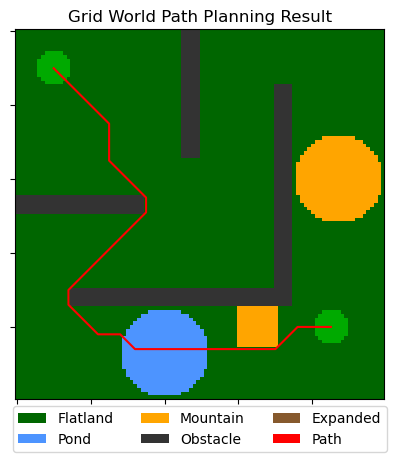

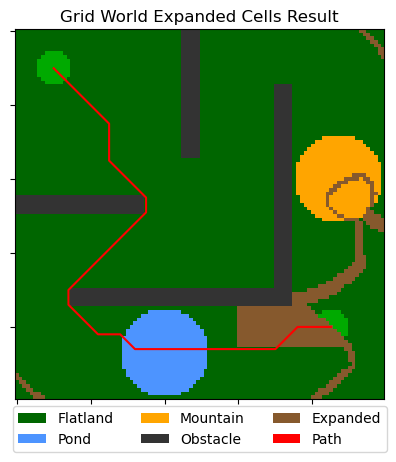

In [31]:
rows=[]
cols=[]
for row in range(75, 86):
    for col in range(60, 71):
        rows.append(row)
        cols.append(col)

searcher.update_costs(rows, cols, 2)
main(searcher)

done!
Path length: 132
Path cost: 146.41778489984145
Number of expanded states: 2849


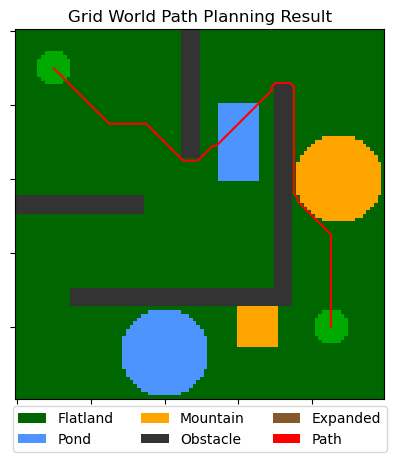

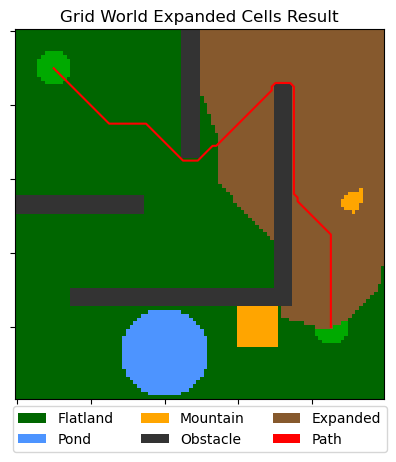

In [33]:
rows=[]
cols=[]
for row in range(20, 41):
    for col in range(55, 66):
        rows.append(row)
        cols.append(col)

searcher.update_costs(rows, cols, 1)

main(searcher)